## Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Задачи:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


In [1]:
!pip install phik==0.10.0 -q
!pip install shap -q
!pip install -U scikit-learn

     |████████████████████████████████| 10.9 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 104.7 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
)
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.dummy import DummyRegressor 
from sklearn.dummy import DummyClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 123

## Задача 1

### Обзор данных

In [5]:
df_train_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv').set_index('id', drop=True)

test_features = pd.read_csv('/datasets/test_features.csv').set_index('id', drop=True)

test_target_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv').set_index('id', drop=True)


In [6]:
# Тренировочная выборка:
df_train_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [7]:
df_train_rate.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [8]:
# Входные признаки тестовой выборки:
test_features = test_features.sort_index()
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [9]:
test_features.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [10]:
# Целевой признак тестовой выборки:
test_target_rate = test_target_rate.sort_index()
test_target_rate.head()

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


In [11]:
test_target_rate.describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


### Предобработка данных

Разделение признаков на категориальные и количественные:

In [12]:
cat_columns = []
num_columns = []

for col_name in df_train_rate.columns:

    if isinstance(df_train_rate[col_name].iloc[0], str):
        cat_columns.append(col_name)
    else:
        num_columns.append(col_name)
num_columns.remove('job_satisfaction_rate')
print('Count numerical columns:', len(num_columns))
print('Count categorical columns:', len(cat_columns))

Count numerical columns: 3
Count categorical columns: 5


Проверка на неявные дубликаты в качественных признаках тренировочной выборки:

In [13]:
def uniq(df):
    for col in df.select_dtypes(include='object').columns:
        print('Уникальные значения столбца', col)
        print(df[col].unique(), '\n')

In [14]:
df_full=df_train_rate.merge(test_features, how='outer')
uniq(df_full)

Уникальные значения столбца dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan ' '] 

Уникальные значения столбца level
['junior' 'middle' 'sinior' nan] 

Уникальные значения столбца workload
['medium' 'high' 'low' ' '] 

Уникальные значения столбца last_year_promo
['no' 'yes'] 

Уникальные значения столбца last_year_violations
['no' 'yes'] 



In [15]:
df_train_rate['level'] = df_train_rate['level'].str.replace('sinior', 'senior')
test_features['level'] = test_features['level'].str.replace('sinior', 'senior')

In [16]:
print(df_train_rate.duplicated().sum())
df_train_rate=df_train_rate.drop_duplicates()

245


#### Вывод

На этапе предобработки данных:
- неявных дубликатов не выявлено
- пропуски будут заполнены внутри пайплайна
- признаки разделены на качественные и количественные

### Исследовательский анализ данных

#### Исследование целевого признака

Сравнение распределения значений целевого признака на тренировочной и тестовой выборке:

In [17]:
train_target_rate=pd.DataFrame(df_train_rate['job_satisfaction_rate'])

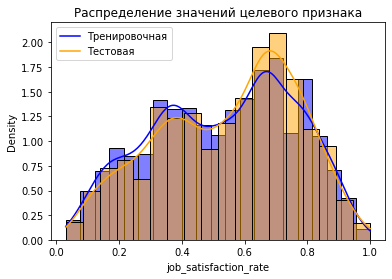

In [18]:
sns.histplot(train_target_rate,  x='job_satisfaction_rate', stat='density', common_norm=False, color='blue', kde=True)
sns.histplot(test_target_rate,  x='job_satisfaction_rate', stat='density', common_norm=False, color='orange', kde=True)
labels= ["Тренировочная","Тестовая"]
plt.legend(labels)
plt.title('Распределение значений целевого признака');

Отмечается схожее распределение значений целевого признака на тестовой и тренировочной выборке, отличное от нормального.

#### Анализ качественных признаков

Тренировочная выборка

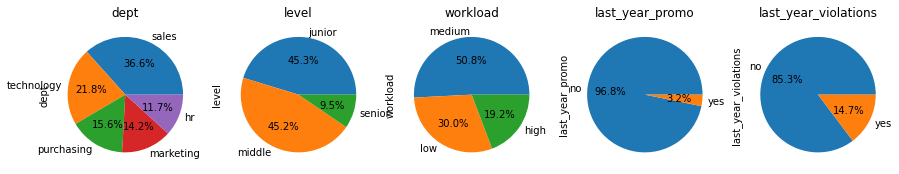

In [19]:
fig, axs = plt.subplots(1, len(cat_columns), figsize=(15, 5))
for i, col in enumerate(cat_columns):
    df_train_rate[col].value_counts().plot(kind='pie',
                              ax=axs[i],
                              title = col,
                              autopct='%1.1f%%')
plt.show();

Тестовая выборка

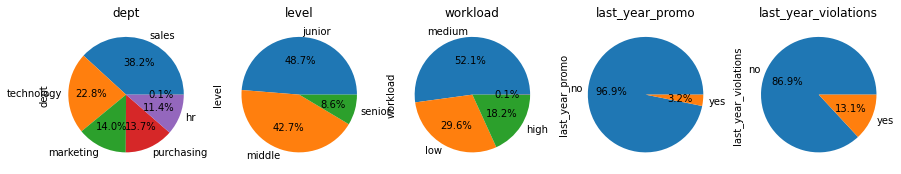

In [20]:
fig, axs = plt.subplots(1, len(cat_columns), figsize=(15, 5))
for i, col in enumerate(cat_columns):
    test_features[col].value_counts().plot(kind='pie',
                              ax=axs[i],
                              title = col,
                              autopct='%1.1f%%')
plt.show();

- Качественные признаки имеют схожее распределение на тренировочной и тестовой выбоорках
- Больше всего сотрудников работает в отеле продаж, меньше всего в hr
- Больше всего сотрудников компании имеют уровень junior и middle
- Большинство сотрудников оценирвают свою рабочую нагрузку как среднюю
- Только около 3% сотрудников получали повышение за последний год
- Меньше 15 % сотрубников нарушали трудовой договор за последний год

#### Анализ количественных признаков

employment_years и supervisor_evaluation - дискретные признаки

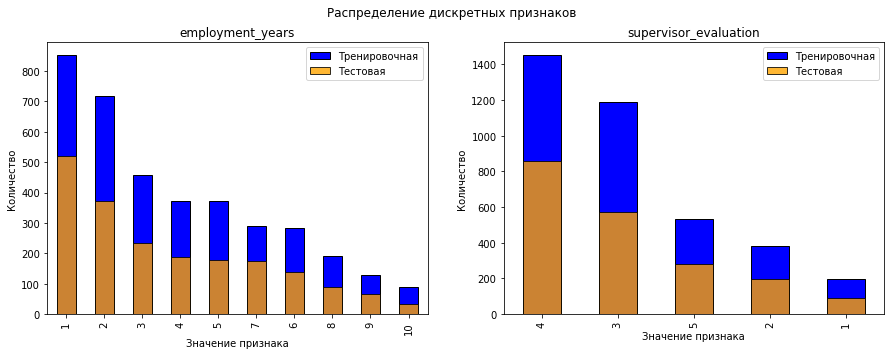

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
# labels= ["Тренировочная","Тестовая"]
plt.suptitle('Распределение дискретных признаков')
df_train_rate['employment_years'].value_counts().plot(
        kind='bar', edgecolor='black', alpha = 1, color='blue', ax=axes[0])
test_features['employment_years'].value_counts().plot(
        kind='bar', edgecolor='black',
        alpha = 0.8, color='orange',
        ax=axes[0],xlabel='Значение признака',
        ylabel='Количество',
        label='Тестовая',
        title='employment_years'
        )
axes[0].legend(['Тренировочная', 'Тестовая'])

df_train_rate['supervisor_evaluation'].value_counts().plot(
        kind='bar', edgecolor='black', alpha = 1, color='blue', ax=axes[1])
test_features['supervisor_evaluation'].value_counts().plot(
        kind='bar', edgecolor='black',
        alpha = 0.8, color='orange',
        ax=axes[1], xlabel='Значение признака',
        title='supervisor_evaluation',
        ylabel='Количество')
axes[1].legend(['Тренировочная', 'Тестовая'])
plt.show();

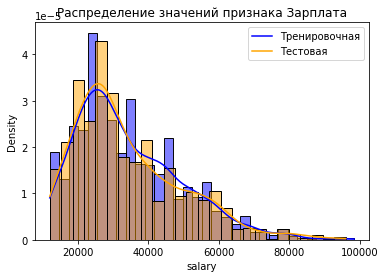

In [22]:
sns.histplot(df_train_rate,  x='salary', stat='density', common_norm=False, color='blue', kde=True)
sns.histplot(test_features,  x='salary', stat='density', common_norm=False, color='orange', kde=True)
labels= ["Тренировочная","Тестовая"]
plt.legend(labels)
plt.title('Распределение значений признака Зарплата');

- Количественные признаки имеют схожее распределение на тренировочной и тестовой выборках
- В компании больше всего молодых специалистов
- Чаще всего руководитель оценивает своих сотрудников на 4
- Пик на графике распределения зарплаты отмечается около 30000, затем идет плавное снижение

### Корреляционный анализ

In [23]:
# for col in cat_columns:
#     sns.pairplot(df_full, x_vars=df_full[num_columns],
#                  y_vars=df_full['job_satisfaction_rate'].name, hue=col)

Тренировочная выборка

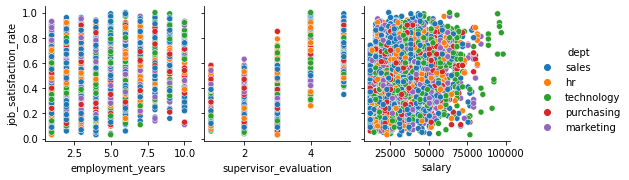

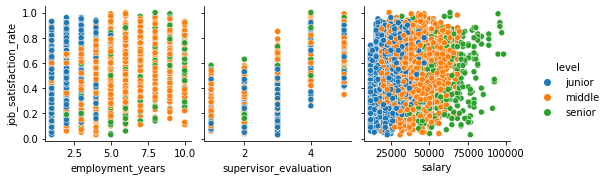

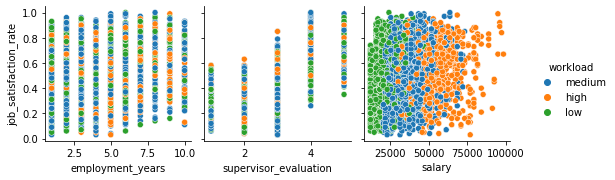

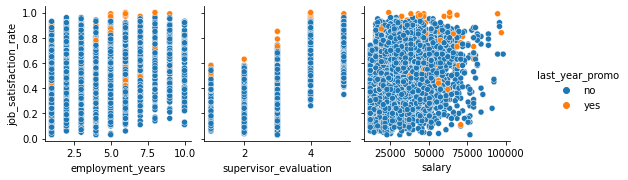

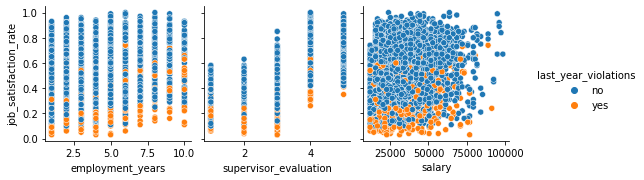

In [24]:
for col in cat_columns:
    sns.pairplot(df_train_rate, x_vars=df_train_rate[num_columns],
                 y_vars=df_train_rate['job_satisfaction_rate'].name, hue=col)

Тестовая выборка и тестовый целевой признак

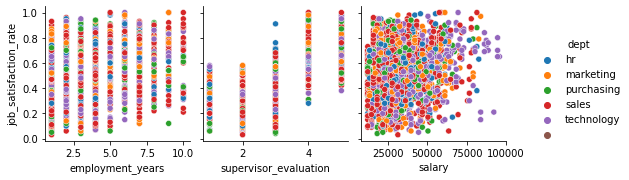

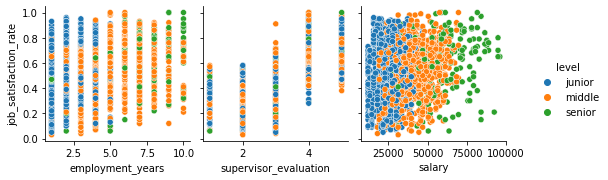

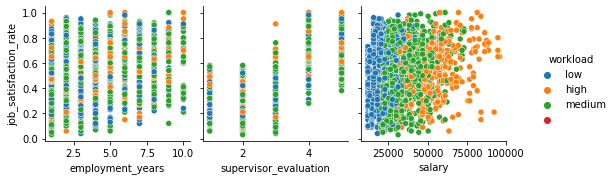

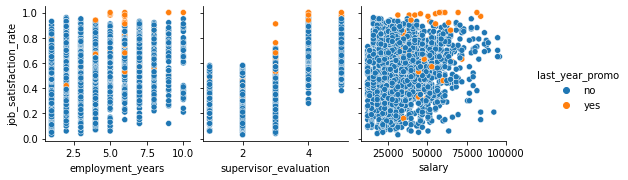

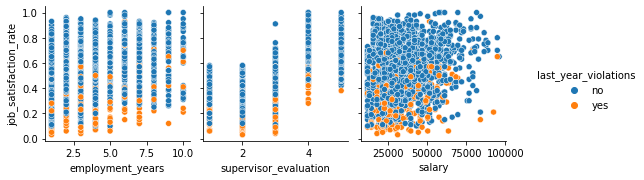

In [25]:
df_test_full=test_features.join(test_target_rate)
for col in cat_columns:
    sns.pairplot(df_test_full, x_vars=df_test_full[num_columns],
                 y_vars=df_test_full['job_satisfaction_rate'].name, hue=col)

Анализируя полученные графики, можно сделать следующие выводы:
- Уровень удовлетворенности сотрудника не зависит от отдела в котором он работает
- Сотрудники, получившие повышение в последний год, редко имеют низкий уровень удовлетворенности работой
- Сотрудники, нарушавшие трудовой договор, часто имеют низкий уровень удовлетворенности
- Как низкий, так и высокий уровень удовлетворенности встречается для любого уровня сотрудника и при любой рабочей нагрузке
- Уровень удовлетворенности сотрудника не зависити от его стажа в этой компании
- Высокая оценка руководителя связа с повышением сотрудника
- Сотрудники, получившие оценку руководителя 4 и 5. не имеют уровень удовлетворенности ниже 0.2

Используем корреляцию Phik, так как признаки не распределены нормально, качественные преобладают над количественными, а которые Phik устойчива к выбросам и ненормальному распределению

In [26]:
# plt.figure(figsize=(8,6))
# sns.heatmap(df_full.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']),
#             cmap='coolwarm',
#             center=0,
#             annot=True,
#             fmt=".1f");

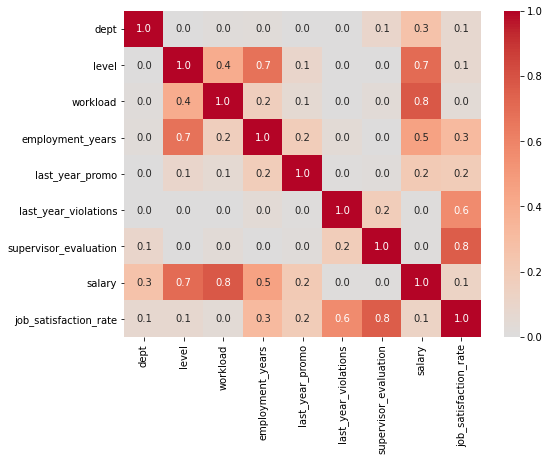

In [27]:
# Тренировочная выборка
plt.figure(figsize=(8,6))
sns.heatmap(df_train_rate.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".1f");

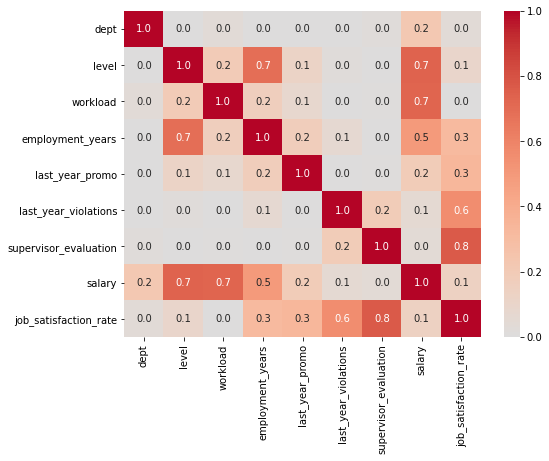

In [28]:
# Тестовая выборка
plt.figure(figsize=(8,6))
sns.heatmap(df_test_full.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".1f");

- Целевой признак лучше всего коррелирует с оценкой руководителя и наличием повышения за последний год
-  Отмечается хорошая корреляция между зарплатой и уровнем должности сотрудника, рабочей нагрузкой, а также трудовым стажем

Корреляция признаков в тренировочной и тестовой выборке очень схожа. Сделаны одинаковые воводы для корреляций между признаками, как по тренировочной, так и по тестовой выборкам.

### Подготовка к моделированию

Метрика для проверки модели:

In [29]:
def SMAPE(y_true, pred):
    return 100/len(y_true)*(np.sum(2*np.abs(y_true-pred)/(np.abs(y_true)+np.abs(pred))))
scorer = make_scorer(SMAPE, greater_is_better=False)

In [30]:
y_train=df_train_rate['job_satisfaction_rate']
X_train=df_train_rate.drop(['job_satisfaction_rate'], axis=1)
y_test=test_target_rate['job_satisfaction_rate']
X_test = test_features

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3755, 8)
(3755,)
(2000, 8)
(2000,)


In [32]:
ohe_columns = ['dept','last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = num_columns

In [33]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_ohe_', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

In [34]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_before_ord_', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low','medium', 'high'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [35]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


In [36]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
     'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 11, 2),
     'models__max_features': range(2, 30, 2),
     'models__min_samples_split': [2, 5, 10],
     'models__min_samples_leaf': [1, 2, 4],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

### Моделирование и анализ важности признаков

In [37]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -1*randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                           

In [38]:
job_satisfaction_rate_pred = randomized_search.predict(X_test)
print(f'Метрика на тестовой выборке: {SMAPE(y_test, job_satisfaction_rate_pred)}')

Метрика на тестовой выборке: 14.68657777057856


In [39]:
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test) 
print(f'Метрика на константной модели: {SMAPE(y_test, y_predict_dummy_mean)}')

Метрика на константной модели: 38.26225790202238


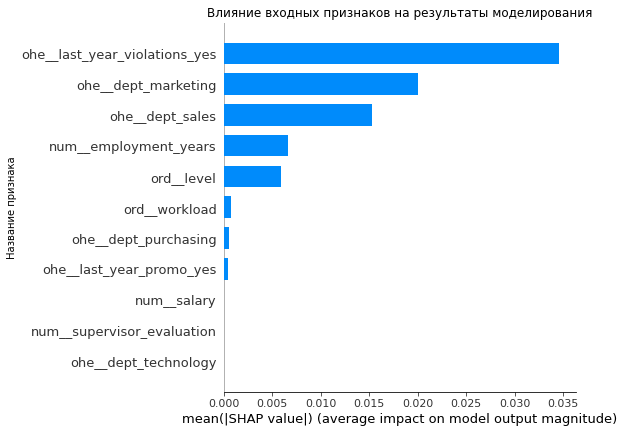

In [40]:
x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
x_Test = pipe_final.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], x_Train)

shap_values = explainer(x_Test)
shap.summary_plot(shap_values, x_Test, plot_type="bar",show=False,
                  feature_names=pipe_final.named_steps['preprocessor'].get_feature_names_out())
plt.title("Влияние входных признаков на результаты моделирования")
plt.ylabel('Название признака')
plt.show()

Мало значимы для модели:
- Оценка руководителя
- Зарплата

Сильнее всего влияют на целевой признак:
- Отдел
- Трудовой стаж
- Факт нарушения трудового договора

#### Вывод:
Лучшая модель:

DecisionTreeRegressor(max_depth=10, max_features=20,
                                       min_samples_leaf=2, random_state=123))])
Метрика лучшей модели на тренировочной выборке: 16.114895122574385
Метрика на тестовой выборке: 14.68657777057856

Модель линейной регрессии не подходит в данном случае из-за отсутсвия высокой линейной корреляции между признаками и преобладанием качественных данных над количественными.

## Задача 2

### Обзор данных

In [41]:
df_train_quit = pd.read_csv('/datasets/train_quit.csv').set_index('id', drop=True)

df_test_features = pd.read_csv('/datasets/test_features.csv').set_index('id', drop=True)

df_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv').set_index('id', drop=True)

In [42]:
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [43]:
df_train_quit.describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [44]:
df_test_features=df_test_features.sort_index()
df_test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [45]:
df_test_target_quit=df_test_target_quit.sort_index()
# df_test_target_quit['quit'] = df_test_target_quit['quit'].apply(
#     lambda x: 1 if x=='yes' else 0)
df_test_target_quit.head()

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


Целевой признак:
quit — увольнение сотрудника из компании.

### Предобработка данных

In [46]:
uniq(df_train_quit)

Уникальные значения столбца dept
['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

Уникальные значения столбца level
['middle' 'junior' 'sinior'] 

Уникальные значения столбца workload
['high' 'medium' 'low'] 

Уникальные значения столбца last_year_promo
['no' 'yes'] 

Уникальные значения столбца last_year_violations
['no' 'yes'] 

Уникальные значения столбца quit
['no' 'yes'] 



In [47]:
uniq(df_test_features)

Уникальные значения столбца dept
['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' '] 

Уникальные значения столбца level
['junior' 'middle' 'sinior' nan] 

Уникальные значения столбца workload
['low' 'high' 'medium' ' '] 

Уникальные значения столбца last_year_promo
['no' 'yes'] 

Уникальные значения столбца last_year_violations
['no' 'yes'] 



In [48]:
df_train_quit['level'] = df_train_quit['level'].str.replace('sinior', 'senior')
df_test_features['level'] = df_test_features['level'].str.replace('sinior', 'senior')

In [49]:
df_test_features.pivot_table(index='level', values='salary', aggfunc=(['min','max']))

,min,max
,salary,salary
level,,
junior,12000,48000
middle,18000,69600
senior,25200,96000


In [50]:
print(df_train_quit.duplicated().sum())
df_train_quit=df_train_quit.drop_duplicates()

1413


### Исследовательский анализ данных

#### Анализ качественных признаков

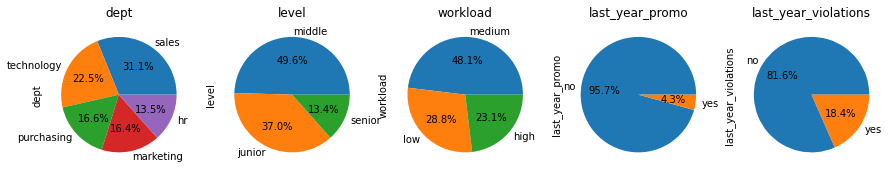

In [51]:
fig, axs = plt.subplots(1, len(cat_columns), figsize=(15, 5))
for i, col in enumerate(cat_columns):
    df_train_quit[col].value_counts().plot(kind='pie',
                              ax=axs[i],
                              title = col,
                              autopct='%1.1f%%')
plt.show();

Во второй задаче в тренировочной выборке:
- преобладает количество сотрудников уровня middle
- преобладает количество сотрудников со средней рабочей нагрузкой
- больше всего сотрудников работает в отделе Продаж, меньше всего в hr, в целом распределение сотрудников по отделам довольно раномерное
- Меньше 5% сотрудников получали повышение в этом году
- около 20% сотрудников нарушали трудовой договор

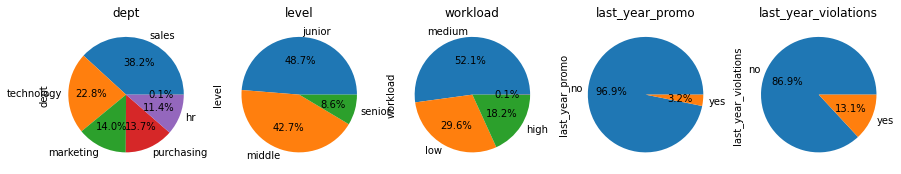

In [52]:
fig, axs = plt.subplots(1, len(cat_columns), figsize=(15, 5))
for i, col in enumerate(cat_columns):
    df_test_features[col].value_counts().plot(kind='pie',
                              ax=axs[i],
                              title = col,
                              autopct='%1.1f%%')
plt.show();

Во второй задаче в тестовой выборке:
- больше всего сотрудников работает в отделе Продаж, меньше всего в hr, в целом распределение сотрудников по отделам довольно раномерное
- преобладает количество сотрудников уровня junior
- преобладает количество сотрудников со средней рабочей нагрузкой
- Меньше 5% сотрудников получали повышение в этом году
- меньше 15% сотрудников нарушали трудовой договор

#### Анализ количественных признаков

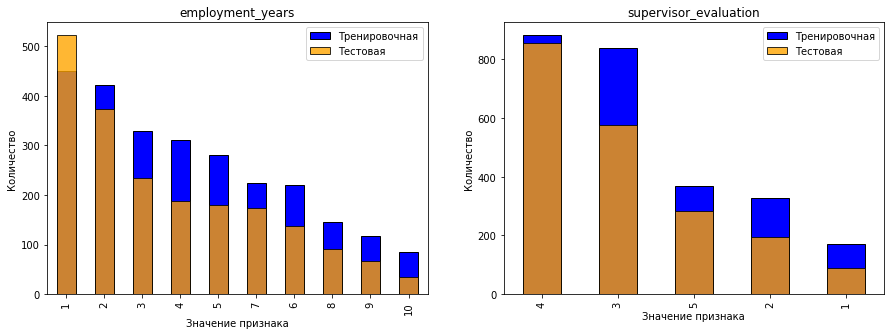

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
df_train_quit['employment_years'].value_counts().plot(
        kind='bar', edgecolor='black',
    alpha = 1, color='blue',
    ax=axes[0], xlabel='Значение признака')
df_test_features['employment_years'].value_counts().plot(
        kind='bar', edgecolor='black', alpha = 0.8,
        color='orange', ax=axes[0], title='employment_years', ylabel='Количество')
axes[0].legend(['Тренировочная', 'Тестовая'])

df_train_quit['supervisor_evaluation'].value_counts().plot(
        kind='bar', edgecolor='black', alpha = 1, color='blue', ax=axes[1], xlabel='Значение признака')
df_test_features['supervisor_evaluation'].value_counts().plot(
        kind='bar', edgecolor='black', alpha = 0.8,
        color='orange', ax=axes[1], title='supervisor_evaluation', ylabel='Количество')

axes[1].legend(['Тренировочная', 'Тестовая'])
plt.xlabel('Значение признака')
plt.show();

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Подписала графики
</div>

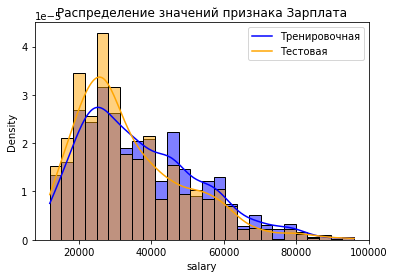

In [54]:
sns.histplot(df_train_quit,  x='salary', stat='density', common_norm=False, color='blue', kde=True)
sns.histplot(df_test_features,  x='salary', stat='density', common_norm=False, color='orange', kde=True)
labels= ["Тренировочная","Тестовая"]
plt.legend(labels)
plt.title('Распределение значений признака Зарплата');

- Количественные признаки имеют схожее распределение на тренировочной и тестовой выборках
- В компании больше всего молодых специалистов
- Чаще всего руководитель оценивает своих сотрудников на 4
- Пик на графике распределения зарплаты отмечается около 30000, затем идет плавное снижение

#### Портрет «уволившегося сотрудника»

In [55]:
df_out=df_train_quit.loc[df_train_quit['quit']=='no']
df_in=df_train_quit.loc[df_train_quit['quit']=='yes']

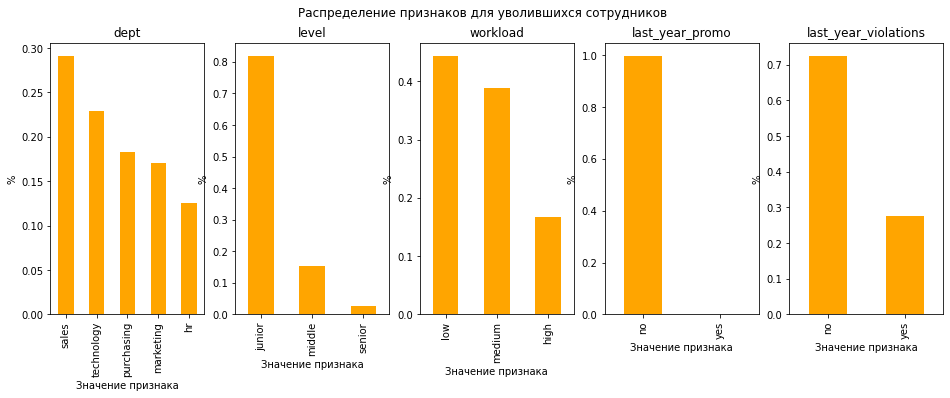

In [56]:
fig, axs = plt.subplots(1, len(cat_columns), figsize=(16, 5))
plt.suptitle('Распределение признаков для уволившихся сотрудников')
for i, col in enumerate(cat_columns):
    df_train_quit.loc[df_train_quit['quit']=='yes'][col].value_counts(normalize=True).plot(kind='bar',
                              ax=axs[i],
                              title = col, color='orange',
                              xlabel='Значение признака',
                              ylabel='%')
plt.show();

Большинство из уволившихся сотрудников имеют уровень junior, и в основном имели небольшую и среднюю рабочую нагрузку. Никто из уволившихся сотрудников не получил премию за последний год работы, но при этом эти сотрудники довольно часто нарушали трудовой договор (каждый третий сотрудних в течении года). 
Распределение по отделам для работающих и уволившихся сотрудников схожее, поэтому поведение уволившегося сотрудника н зависит от отдела в котором он работает.

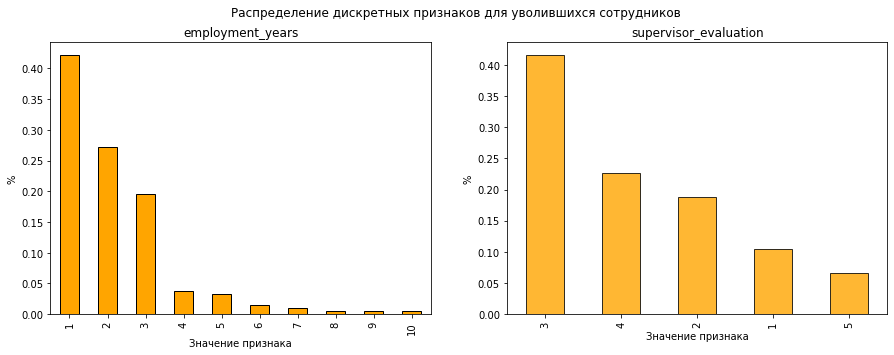

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.suptitle('Распределение дискретных признаков для уволившихся сотрудников')
df_train_quit.loc[df_train_quit['quit']=='yes']['employment_years'].value_counts(normalize=True).plot(
        kind='bar',
        edgecolor='black',
        alpha = 1, 
        color='orange', 
        ax=axes[0],
        title='employment_years', xlabel='Значение признака', ylabel='%')
df_train_quit.loc[df_train_quit['quit']=='yes']['supervisor_evaluation'].value_counts(normalize=True).plot(
        kind='bar',
        edgecolor='black',
        alpha = 0.8,
        color='orange',
        ax=axes[1],
        title='supervisor_evaluation', xlabel='Значение признака', ylabel='%')
plt.show();

Уволившиеся сотрудники получали средние оценки от руководителя 3 и 4, а также имели маленький стаж работы в компании до 3 лет.

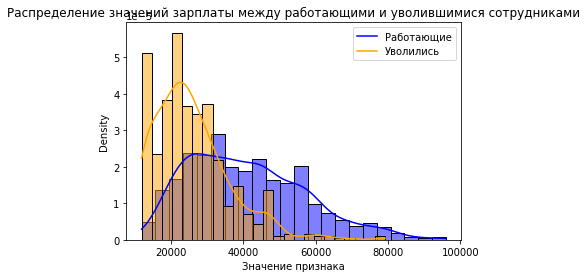

Средняя зарплата уволившегося сотрудника 25767.93893129771
Средняя зарплата работающего сотрудника 40952.17391304348


In [58]:
sns.histplot(df_train_quit.loc[df_train_quit['quit']=='no'],  x='salary', stat='density', common_norm=False, color='blue', kde=True)
sns.histplot(df_train_quit.loc[df_train_quit['quit']=='yes'],  x='salary', stat='density', common_norm=False, color='orange', kde=True)
labels= ["Работающие","Уволились"]
plt.xlabel('Значение признака')
plt.title('Распределение значений зарплаты между работающими и уволившимися сотрудниками')
plt.legend(labels)
plt.show();
print('Средняя зарплата уволившегося сотрудника', 
      df_train_quit.loc[df_train_quit['quit']=='yes']['salary'].mean())
print('Средняя зарплата работающего сотрудника', 
      df_train_quit.loc[df_train_quit['quit']=='no']['salary'].mean())

#### Исследование целевого признака

In [59]:
df_test_features['job_satisfaction_rate']=job_satisfaction_rate_pred
df_train_quit['job_satisfaction_rate']=randomized_search.predict(df_train_quit)

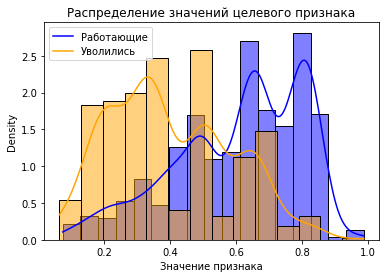

In [60]:
sns.histplot(df_test_features.loc[df_test_target_quit['quit']=='no'],  x='job_satisfaction_rate', stat='density', common_norm=False, color='blue', kde=True)
sns.histplot(df_test_features.loc[df_test_target_quit['quit']=='yes'],  x='job_satisfaction_rate', stat='density', common_norm=False, color='orange', kde=True)
labels= ["Работающие","Уволились"]
plt.xlabel('Значение признака')
plt.title('Распределение значений целевого признака')
plt.legend(labels)
plt.show();

Уволившиеся сотрудники имеют уровень удовлетворенности в большинстве случаев не выше 0.55. Большая часть неуволившихся сотрудников наоборот имеет уровень удовлетворенности выше 0.55.

In [61]:
df_train_target_quit = pd.DataFrame(df_train_quit['quit'])

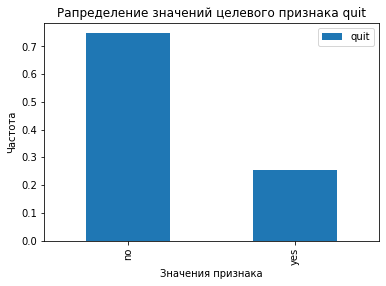

In [62]:
df_train_target_quit['quit'].value_counts(normalize=True).plot(
    kind='bar',
    title='quit');
plt.title('Рапределение значений целевого признака quit')
plt.legend()
plt.xlabel('Значения признака')
plt.ylabel('Частота')
plt.show();

В целевом признаке отмечен сильный дисбаланс классов.
Дисбаланс классов объясняется спецификой задачи, так как факт увольнения фиксируется для небольшого процента покупателей. Нельзя устранить такой дисбаланс, не нарушив закономерности данных.

#### Вывод

Во второй задаче в тренировочной выборке:
- преобладает количество сотрудников уровня middle
- преобладает количество сотрудников со средней рабочей нагрузкой
- больше всего сотрудников работает в отделе Продаж, меньше всего в hr, в целом распределение сотрудников по отделам довольно раномерное
- Меньше 5% сотрудников получали повышение в этом году
- около 20% сотрудников нарушали трудовой договор

Во второй задаче в тестовой выборке:
- больше всего сотрудников работает в отделе Продаж, меньше всего в hr, в целом распределение сотрудников по отделам довольно раномерное
- преобладает количество сотрудников уровня junior
- преобладает количество сотрудников со средней рабочей нагрузкой
- Меньше 5% сотрудников получали повышение в этом году
- меньше 15% сотрудников нарушали трудовой договор

- Количественные признаки имеют схожее распределение на тренировочной и тестовой выборках
- В компании больше всего молодых специалистов
- Чаще всего руководитель оценивает своих сотрудников на 4
- Пик на графике распределения зарплаты отмечается около 30000, затем идет плавное снижение

**Портрет уволившегося сотрудника**:
Большинство из уволившихся сотрудников имеют уровень junior, и в основном имели небольшую и среднюю рабочую нагрузку. Никто из уволившихся сотрудников не получил премию за последний год работы, но при этом эти сотрудники довольно часто нарушали трудовой договор (каждый третий сотрудних в течении года). 
Распределение по отделам для работающих и уволившихся сотрудников схожее, поэтому поведение уволившегося сотрудника н зависит от отдела в котором он работает.
Уволившиеся сотрудники получали средние оценки от руководителя 3 и 4, а также имели маленький стаж работы в компании до 3 лет.
Уволившиеся сотрудники имели более низкую заработную плату:
- Средняя зарплата уволившегося сотрудника 25767.93893129771
- Средняя зарплата работающего сотрудника 40952.17391304348

Уволившиеся сотрудники имеют уровень удовлетворенности в большинстве случаев не выше 0.55. Большая часть неуволившихся сотрудников наоборот имеет уровень удовлетворенности выше 0.55.

По результатам анализа в целевом признаке отмечен сильный дисбаланс классов.
Дисбаланс классов объясняется спецификой задачи, так как факт увольнения фиксируется для небольшого процента покупателей. Нельзя устранить такой дисбаланс, не нарушив закономерности данных.

### Подготовка к моделированию

In [63]:
le = LabelEncoder()
le.fit_transform(df_train_target_quit)
le.transform(df_test_target_quit)

array([0, 0, 0, ..., 1, 0, 1])

In [64]:
df_train_quit=df_train_quit.drop(['quit'], axis=1)

In [65]:
ohe_columns = ['dept','last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation','job_satisfaction_rate']

In [66]:
y_train2=df_train_target_quit['quit']
X_train2=df_train_quit[ohe_columns+ord_columns+num_columns]
y_test2=df_test_target_quit['quit']
X_test2= df_test_features[ohe_columns+ord_columns+num_columns]

print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(2587, 9)
(2587,)
(2000, 9)
(2000,)


In [67]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_ohe_', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_before_ord_', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low','medium', 'high'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2,15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

#     {
#         'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
#         'models__n_estimators': range(2, 20),
#         'models__max_features': ['sqrt', 'log2', None],
#         'models__max_depth': range(2, 15),
#         'models__max_leaf_nodes': range(1, 15),
#         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
#     },

#     словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
#     {
#         'models': [LogisticRegression(
#             random_state=RANDOM_STATE,
#             solver='liblinear',
#             penalty='l1'
#         )],
#         'models__C': range(1,5),
#         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
#     },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.01,1,10],
        'models__kernel': ['linear', 'poly', 'rbf'],
        'models__degree': ['1', '2', '3', '4']

    }
]

In [68]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train2, y_train2)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                           

In [69]:
quit_test_pred_proba = randomized_search.predict_proba(X_test2)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test2, quit_test_pred_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.922342030660424


In [70]:
lm_dummy = DummyClassifier().fit(X_train2, y_train2)
y_predict_dummy = lm_dummy.predict_proba(X_test2)[:, 1]
print(f'Метрика на константной модели: {roc_auc_score(y_test2, y_predict_dummy_mean)}')

Метрика на константной модели: 0.5


## Общий вывод

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Задачами работы являлись:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Целевой признак для первой задачи - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, моделирование необходимо выполнять методами регрессии.
Целевой признак для второй задачи - quit — увольнение сотрудника из компании, моделирование необходимо выполнять методами классификации.

Задача 1:

На этапе предобработки данных:
- неявных дубликатов не выявлено
- пропуски будут заполнены внутри пайплайна
- признаки разделены на качественные и количественные

Отмечается одинаковое распределение значений целевого признака на тестовой и тренировочной выборке, отличное от нормального.

- Качественные признаки имеют схожее распределение на тренировочной и тестовой выбоорках
- Больше всего сотрудников работает в отеле продаж, меньше всего в hr
- Больше всего сотрудников компании имеют уровень junior и middle
- Большинство сотрудников оценирвают свою рабочую нагрузку как среднюю
- Только около 3% сотрудников получали повышение за последний год
- Меньше 15 % сотрубников нарушали трудовой договор за последний год

- Количественные признаки имеют схожее распределение на тренировочной и тестовой выборках
- В компании больше всего молодых специалистов
- Чаще всего руководитель оценивает своих сотрудников на 4
- Пик на графике распределения зарплаты отмечается около 30000, затем идет плавное снижение


Результаты корреляционного анализа:
- Уровень удовлетворенности сотрудника не зависит от отдела в котором он работает
- Сотрудники, получившие повышение в последний год, редко имеют низкий уровень удовлетворенности работой
- Сотрудники, нарушавшие трудовой договор, часто имеют низкий уровень удовлетворенности
- Как низкий, так и высокий уровень удовлетворенности встречается для любого уровня сотрудника и при любой рабочей нагрузке
- Уровень удовлетворенности сотрудника не зависити от его стажа в этой компании
- Высокая оценка руководителя связа с повышением сотрудника
- Сотрудники, получившие оценку руководителя 4 и 5. не имеют уровень удовлетворенности ниже 0.2
- Целевой признак лучше всего коррелирует с оценкой руководителя и наличием повышения за последний год
- Отмечается хорошая корреляция между зарплатой и уровнем должности сотрудника, рабочей нагрузкой, а также трудовым стажем

Лучшая модель в 1 задаче:
DecisionTreeRegressor(max_depth=10, max_features=20,
                                       min_samples_leaf=2, random_state=123))])
Метрика лучшей модели на тренировочной выборке: 16.114895122574385
Метрика на тестовой выборке: 14.68657777057856

Мало значимы для модели:
- Отдел, в котором работает сотрудник
- Наличие повышения

Сильнее всего влияют на целевой признак:
- Стаж сотрудника в этой компании
- Оценка руководителя
- Факт нарушения трудового договора
- Зарплата

Задача 2:


В целевом признаке (quit) отмечен сильный дисбаланс классов.
Дисбаланс классов объясняется спецификой задачи, так как факт увольнения фиксируется для небольшого процента покупателей. Нельзя устранить такой дисбаланс, не нарушив закономерности данных.

Лучшая модель во 2 задаче:
DecisionTreeClassifier(max_depth=5, max_features=14,
                                        min_samples_leaf=5,
                                        min_samples_split=11,
                                        random_state=123))])
Метрика лучшей модели на тренировочной выборке: 0.9024471305238141
Метрика ROC-AUC на тестовой выборке: 0.922342030660424

**Портрет уволившегося сотрудника**:
Большинство из уволившихся сотрудников имеют уровень junior, и в основном имели небольшую и среднюю рабочую нагрузку. Никто из уволившихся сотрудников не получил премию за последний год работы, но при этом эти сотрудники довольно часто нарушали трудовой договор (каждый третий сотрудних в течении года). 
Распределение по отделам для работающих и уволившихся сотрудников схожее, поэтому поведение уволившегося сотрудника н зависит от отдела в котором он работает.
Уволившиеся сотрудники получали средние оценки от руководителя 3 и 4, а также имели маленький стаж работы в компании до 3 лет.
Уволившиеся сотрудники имели более низкую заработную плату:
Средняя зарплата уволившегося сотрудника 25767.93893129771
Средняя зарплата работающего сотрудника 40952.17391304348
Уволившиеся сотрудники имеют уровень удовлетворенности в большинстве случаев не выше 0.55. Большая часть неуволившихся сотрудников наоборот имеет уровень удовлетворенности выше 0.55.

**Рекомендация:**
Бизнесу необходимо чаще обращать внимание на уровень удовлетворенности сотрудников уровня junior и чаще проводить оценку качества их работы и повышения. Молодые специалист не получают повышение и не довольны уровнем заработной платы, скорее всего факт нарушения трудового договора вызван имено недовльством сотрудников условиями работы. Уволившиеся сотрудники часто получали от руководитея оценку 4, что говорит о том, что в общем он был доволен работой сотрудника, поэтому компания теряет хорошие кадры, к тому же многие из уволившихся отработали в компании уже несколько лет.